In [67]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import scipy.optimize 
from sklearn import svm 
from stemming.porter2 import stem
import nltk, nltk.stem.porter
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [24]:
datafile = 'data/ex6data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])
print(neg)

[[1.5841  3.3575 ]
 [2.0103  3.2039 ]
 [1.9527  2.7843 ]
 [2.2753  2.7127 ]
 [2.3099  2.9584 ]
 [2.8283  2.6309 ]
 [3.0473  2.2931 ]
 [2.4827  2.0373 ]
 [2.5057  2.3853 ]
 [1.8721  2.0577 ]
 [2.0103  2.3546 ]
 [1.2269  2.3239 ]
 [1.8951  2.9174 ]
 [1.561   3.0709 ]
 [1.5495  2.6923 ]
 [1.6878  2.4057 ]
 [1.4919  2.0271 ]
 [0.962   2.682  ]
 [1.1693  2.9276 ]
 [0.8122  2.9992 ]
 [0.9735  3.3881 ]
 [1.25    3.1937 ]
 [1.3191  3.5109 ]
 [2.2292  2.201  ]
 [2.4482  2.6411 ]
 [2.7938  1.9656 ]
 [2.091   1.6177 ]
 [2.5403  2.8867 ]
 [0.9044  3.0198 ]
 [0.76615 2.5899 ]]


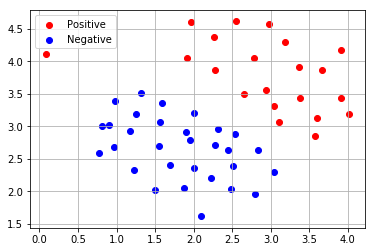

In [25]:
def plotData():
    plt.scatter(pos[:,0],pos[:,1],c='r',label='Positive')
    plt.scatter(neg[:,0],neg[:,1],c='b',label='Negative')
    plt.legend()
    plt.grid(True)
    
plotData()

In [26]:
def plot_svm(my_svm, xmin, xmax, ymin, ymax):
    xvals = np.linspace(xmin,xmax,100)
    yvals = np.linspace(ymin,ymax,100)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            zvals[i][j] = float(my_svm.predict(np.array([xvals[i],yvals[j]]).reshape(1,-1)))
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    plt.title("Decision Boundary")

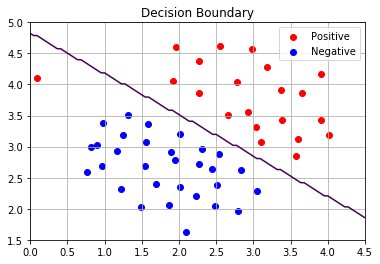

In [27]:
linear_svm = svm.SVC(C=1, kernel='linear')
linear_svm.fit( X, y.flatten() )
plotData()
plot_svm(linear_svm,0,4.5,1.5,5)

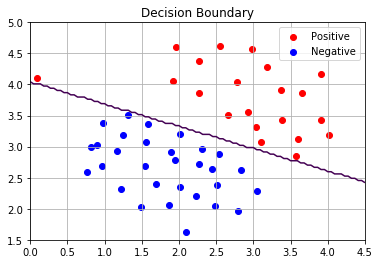

In [28]:
linear_svm = svm.SVC(C=100, kernel='linear')
linear_svm.fit( X, y.flatten() )
plotData()
plot_svm(linear_svm,0,4.5,1.5,5)

## Gaussian Kernels

In [32]:
def gaussian_kernel(x1, x2, sigma=2):
    norm = (x1-x2).T.dot(x1-x2)
    return(np.exp(-norm/(2*sigma**2)))

In [33]:
datafile = 'data/ex6data2.mat'
mat = scipy.io.loadmat( datafile )
#Training set
X, y = mat['X'], mat['y']

#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

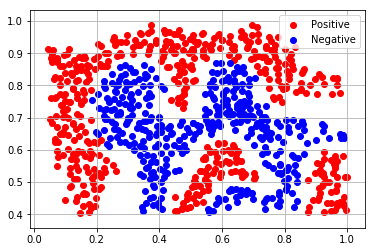

In [34]:
plotData()

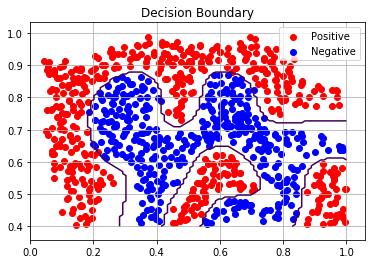

In [36]:
sigma = 0.1
gamma = np.power(sigma,-2.)
gaus_svm = svm.SVC(C=1, kernel='rbf', gamma=gamma)
gaus_svm.fit( X, y.flatten() )
plotData()
plot_svm(gaus_svm,0,1,.4,1.0)

In [38]:
datafile = 'data/ex6data3.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
Xval, yval = mat['Xval'], mat['yval']

pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

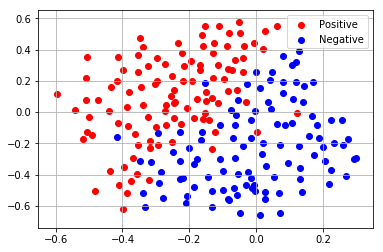

In [39]:
plotData()

In [42]:
Cvalues = (0.01, 0.03, 0.1, 0.3, 1., 3., 10., 30.)
sigmavalues = Cvalues
best_pair, best_score = (0, 0), 0

for Cvalue in Cvalues:
    for sigmavalue in sigmavalues:
        gamma = np.power(sigmavalue,-2.)
        gaus_svm = svm.SVC(C=Cvalue, kernel='rbf', gamma=gamma)
        gaus_svm.fit( X, y.flatten() )
        this_score = gaus_svm.score(Xval,yval)
        if this_score > best_score:
            best_score = this_score
            best_pair = (Cvalue, sigmavalue)
            
print("Best C, sigma pair is (%f, %f) with a score of %f."%(best_pair[0],best_pair[1],best_score))

Best C, sigma pair is (0.300000, 0.100000) with a score of 0.965000.


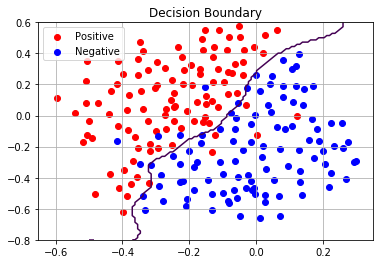

In [43]:
gaus_svm = svm.SVC(C=best_pair[0], kernel='rbf', gamma = np.power(best_pair[1],-2.))
gaus_svm.fit( X, y.flatten() )
plotData()
plot_svm(gaus_svm,-.5,.3,-.8,.6)

## Spam Classification

### Text Preprocessing

In [49]:
print("emailSample1.txt:")
!cat data/emailSample1.txt

emailSample1.txt:
> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com



In [51]:
def process_text( email ):
    email = email.lower()
    email = re.sub('<[^<>]+>', ' ', email);
    email = re.sub('[0-9]+', 'number', email)
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email)
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email);
    email = re.sub('[$]+', 'dollar', email);
    return email

In [62]:
def tokenize( raw_email ):
    stemmer = nltk.stem.porter.PorterStemmer()
    email = process_text( raw_email )
    tokens = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', email)
    tokenlist = []
    for token in tokens:
        token = re.sub('[^a-zA-Z0-9]', '', token);
        stemmed = stemmer.stem( token )
        if not len(token): continue
        tokenlist.append(stemmed)      
    return tokenlist

In [63]:
def get_vocab(reverse=False):
    vocab_dict = {}
    with open("data/vocab.txt") as f:
        for line in f:
            (val, key) = line.split()
            if not reverse:
                vocab_dict[key] = int(val)
            else:
                vocab_dict[int(val)] = key
                
    return vocab_dict

In [64]:
def get_vocab_indices( raw_email, vocab_dict ):
    tokenlist = tokenize( raw_email )
    index_list = [ vocab_dict[token] for token in tokenlist if token in vocab_dict ]
    return index_list

In [65]:
def extract_features( raw_email, vocab_dict ):
    n = len(vocab_dict)
    result = np.zeros((n,1))
    vocab_indices = get_vocab_indices( email_contents, vocab_dict )
    for idx in vocab_indices:
        result[idx] = 1
    return result

In [73]:
vocab_dict = get_vocab()
email_contents = open( 'data/emailSample1.txt', 'r' ).read()
test_fv = extract_features( email_contents, vocab_dict )

print("Length of feature vector: %d" % len(test_fv))
print("Number of entries: %d" % sum(test_fv==1))

Length of feature vector: 1899
Number of entries: 45


### SVM Training

In [101]:
datafile = 'data/spamTrain.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']

datafile = 'data/spamTest.mat'
mat = scipy.io.loadmat( datafile )
Xtest, ytest = mat['Xtest'], mat['ytest']

In [102]:
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])
print('# of training emails = ',X.shape[0])
print('# training spam emails = ',pos.shape[0])
print('# training nonspam emails = ',neg.shape[0])

# of training emails =  4000
# training spam emails =  1277
# training nonspam emails =  2723


In [103]:
myCs = [ 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0 ]
myErrors = []
myErrors_train = []

for myC in myCs:
    linear_svm = svm.SVC(C=myC, kernel='linear')
    linear_svm.fit( X, y.flatten() )
    cv_predictions = linear_svm.predict(Xtest).reshape((ytest.shape[0],1))
    cv_error = 100. * float(sum(cv_predictions != ytest))/ytest.shape[0]
    myErrors.append( cv_error )
    train_predictions = linear_svm.predict(X).reshape((y.shape[0],1))
    train_error = 100. * float(sum(train_predictions != y))/y.shape[0]
    myErrors_train.append( train_error )

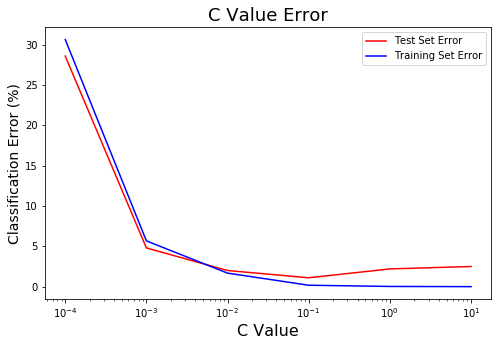

In [107]:
plt.figure(figsize=(8,5))
plt.plot(myCs,myErrors,'r',label='Test Set Error')
plt.plot(myCs,myErrors_train,'b',label='Training Set Error')
plt.xlabel('C Value',fontsize=16)
plt.ylabel('Classification Error (%)',fontsize=14)
plt.title('C Value Error',fontsize=18)
plt.xscale('log')
myleg = plt.legend()

In [95]:
linear_svm = svm.SVC(C=0.1, kernel='linear')
linear_svm.fit( X, y.flatten() )

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [83]:
train_predictions = linear_svm.predict(X).reshape((y.shape[0],1))
train_acc = 100. * float(sum(train_predictions == y))/y.shape[0]
print('Training accuracy = %0.2f%%' % train_acc)

test_predictions = linear_svm.predict(Xtest).reshape((ytest.shape[0],1))
test_acc = 100. * float(sum(test_predictions == ytest))/ytest.shape[0]
print('Test set accuracy = %0.2f%%' % test_acc)

Training accuracy = 99.83%
Test set accuracy = 98.90%
